# Singularity Hub Build Consistency
This notebook will assess consistency of Singularity Hub builds for three different container collections:

 - vsoch/singularity-hello-world
 - vsoch/pe-predictive
 - researchapps/quantum_state_diffusion
 
 For each, an optimal outcome is to see no significant differences between size estimated for the build, and build time in seconds. We hypothesize that our software pipeline and infrastructure for Singularity Hub will make this the case. The code to download the metrics is provided in this repo folder (`download_metrics.py`), and was run to produce the contents of `results.pkl` that is read in the example.

## Comparing Size and Build Time
We will next load in the results file (assuming we don't have it in the running notebook's memory), load the result data frame, and then look at the metrics size and build time.

In [1]:
import numpy
import os
import pickle

container_names = ['vsoch/singularity-hello-world',
                   'researchapps/quantum_state_diffusion',
                   'vsoch/pe-predictive']

base = "/home/vanessa/Documents/Work/singularity/hub"
results = pickle.load(open('%s/results.pkl' %base,'rb'))
df = results['df']

metrics = ['size','build_time_seconds']

In [7]:
from scipy import stats
import pandas
                                      # means and standard deviation, and T statistic
metrics_df = pandas.DataFrame(columns=['size_mean','size_std','build_time_mean','build_time_std'])
for container_name in container_names:
    sizes = df[df.name==container_name].size
    times = df[df.name==container_name].build_time_seconds
    metrics_df.loc[container_name] = [sizes.mean(),sizes.std(),times.mean(),times.std()]
    
metrics_df.columns = ['Size Mean (GB)','Size STD (GB)','Build Time Mean (sec)','Build Time STD (sec)']
metrics_df

,Size Mean (GB),Size STD (GB),Build Time Mean (sec),Build Time STD (sec)
vsoch/singularity-hello-world,80.0,0.0,12.312500,1.138347
researchapps/quantum_state_diffusion,120.0,0.0,649.875000,41.047494
vsoch/pe-predictive,75.0,0.0,2687.066667,208.283964


From the above, we see that there is absolutely no variance for sizes of images, however there is variance for the build times. We would really want to know if 200 seconds (3 1.3 minutes) is significantly different given the total build time, etc.

### Is Build Time Significantly Different?

We can use a one sample T-test to determine if any of the values in the distribution of build times are significantly different from the mean (p<=0.05)

In [8]:
for container_name in container_names:
    times = df[df.name==container_name].build_time_seconds
    times_t = stats.ttest_1samp(times,times.mean())
    metrics_df.loc[container_name,'Build Time T-Stat'] = times_t.statistic
    metrics_df.loc[container_name,'Build Time P-Value'] = times_t.pvalue

metrics_df

,Size Mean (GB),Size STD (GB),Build Time Mean (sec),Build Time STD (sec),Build Time T-Stat,Build Time P-Value
vsoch/singularity-hello-world,80.0,0.0,12.312500,1.138347,0.0,1.0
researchapps/quantum_state_diffusion,120.0,0.0,649.875000,41.047494,0.0,1.0
vsoch/pe-predictive,75.0,0.0,2687.066667,208.283964,0.0,1.0


We see that the build times are not significantly different. This will be an interesting to look at across different cloud provides, and locally with another analysis. Finally, we provide plots of the different build times for the viewer.

## Build Time Distributions

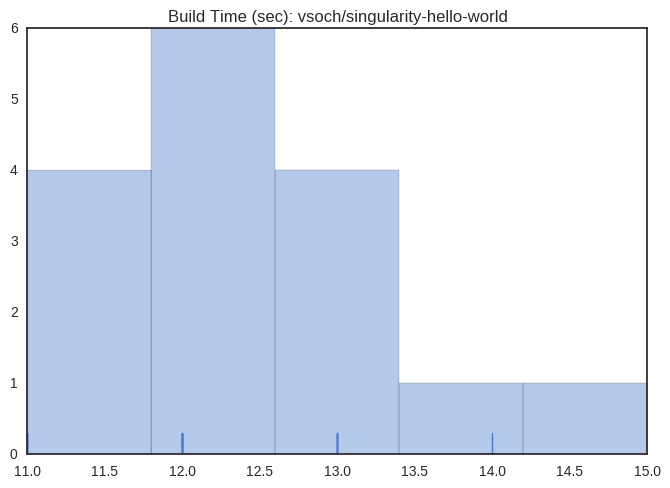

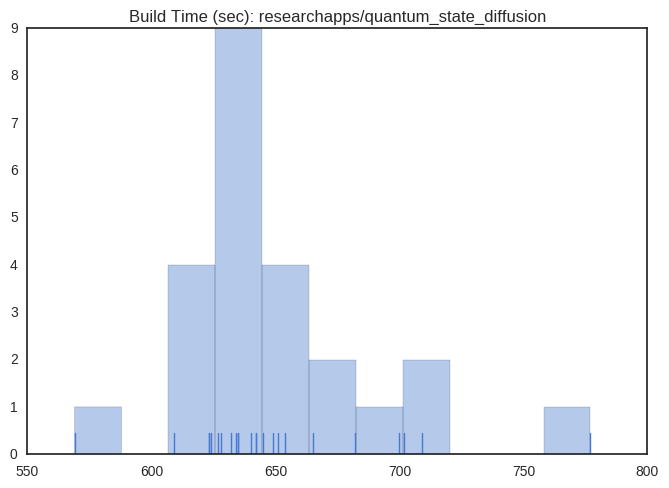

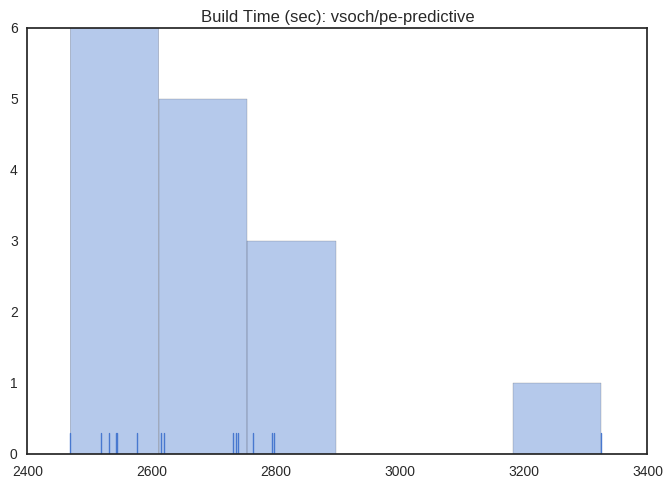

In [10]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
sns.set(style="white", palette="muted", color_codes=True)

for c in range(len(container_names)):
    container_name = container_names[c]  
    values = df[df.name == container_name].build_time_seconds.tolist()
    plt.figure()
    sns.distplot(values, kde=False, rug=True)
    sns.plt.title('Build Time (sec): %s' %(container_name))

This larger range of times for bigger images is not surprising because pe-predictive requires download of python's [nltk](http://www.nltk.org/install.html), which is a huge package, and likely the huge variance has to do with differences in downloading those files, and then installing all required parsers, corpus, etc. with `nltk.download('all')`. Quantum state diffusion is also a large image that requires many Python dependencies, and they come from the anaconda (conda) package manager. `vsoch/singularity-hello-world` represents the build process for a container that requires no download, but just image generation with specifications for the image by the bootstrap file. In this case, Docker image layers were downloaded for the base, and a custom runscript generated. It obviously is very fast.